In [1]:
import sys
import os

sys.path.append(os.path.join(os.getcwd(), ".."))


import torch
import torch.nn as nn
import torchinfo
from tqdm.notebook import tqdm 

from torchvision.datasets import Caltech101
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms


from vision_transformer.VisionTransformer import ViT
from src.read_config import read_config

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
name = 'architecture_2.yaml'
config = read_config(config_path='../configs', config_name=name)
config

{'inputs': {'img_size': 96, 'in_channels': 3}, 'params': {'patch_size': 8, 'd_model': 512, 'dropout_rate': 0.5, 'n_encoder_blocks': 2, 'n_heads': 4, 'ff_size': 1024}}

In [3]:
class TransformerClassifier(nn.Module): 
    def __init__(self, n_classes, img_size: int, in_channels: int, transformer_config): 
        super().__init__()
        
        self.n_classes = n_classes
        self.img_size = img_size
        self.in_channels = in_channels
        self.transformer_config = transformer_config
        
        self.vit = ViT(img_size=img_size, in_channels=in_channels, **self.transformer_config)

        self.classifier = nn.Sequential(
            nn.Linear(self.vit.d_model, self.n_classes), 
            nn.ReLU(), 
        )
        
    def forward(self, x): 
        embeddins = self.vit(x)
        logits = self.classifier(embeddins)
        
        return logits

In [4]:
model = TransformerClassifier(n_classes=101, img_size=96, in_channels=3, transformer_config=config['params'])
model.load_state_dict(torch.load('architecture_2.pth', weights_only=True))
model.eval()

TransformerClassifier(
  (vit): ViT(
    (embedder): PatchEmbedder(
      (embedder): Conv2d(3, 512, kernel_size=(8, 8), stride=(8, 8))
    )
    (position_encoder): PositionalEncoding()
    (encoder): Encoder(
      (layers): ModuleList(
        (0-1): 2 x EncoderBlock(
          (attention_block): MultiHeadAttention(
            (query_transform): Linear(in_features=512, out_features=512, bias=True)
            (key_transform): Linear(in_features=512, out_features=512, bias=True)
            (value_transform): Linear(in_features=512, out_features=512, bias=True)
            (w_o): Linear(in_features=512, out_features=512, bias=True)
            (dropout): Dropout(p=0.5, inplace=False)
          )
          (feed_forward_block): FeedForwardBlock(
            (feed_forward): Sequential(
              (0): Linear(in_features=512, out_features=1024, bias=True)
              (1): GELU(approximate='none')
              (2): Dropout(p=0.5, inplace=False)
              (3): Linear(in_feature

In [5]:
from PIL import Image

image = Image.open("data/testing_images/cat.jpg")
transform = transforms.Compose([transforms.PILToTensor(), transforms.Resize((456, 696))])
img_tensor = transform(image)/255

(57, 87)


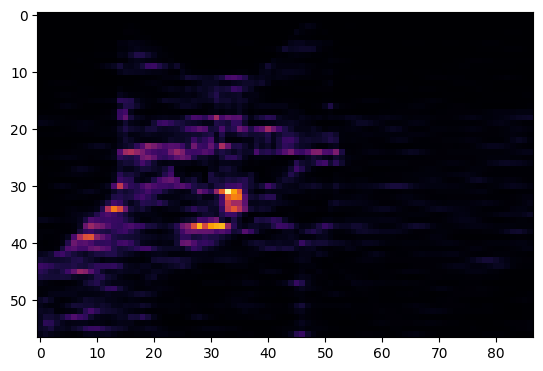

(57, 87)


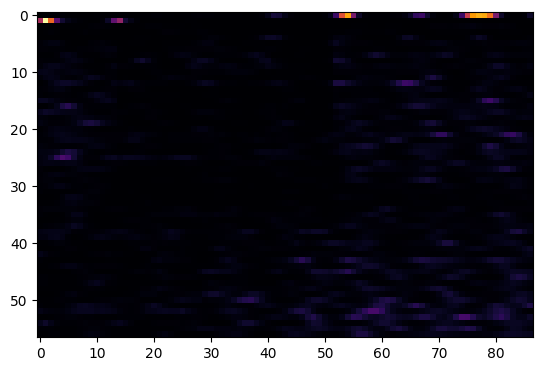

(57, 87)


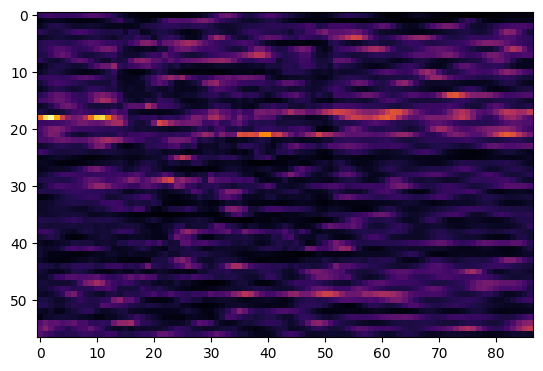

(57, 87)


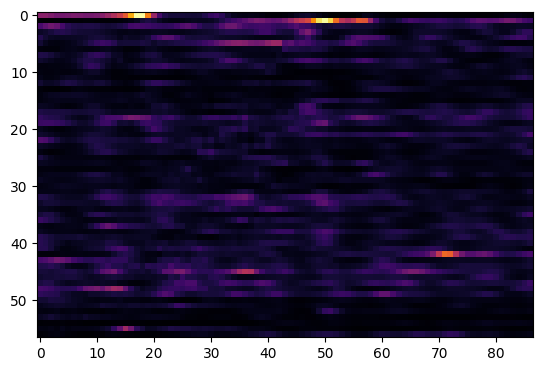

min


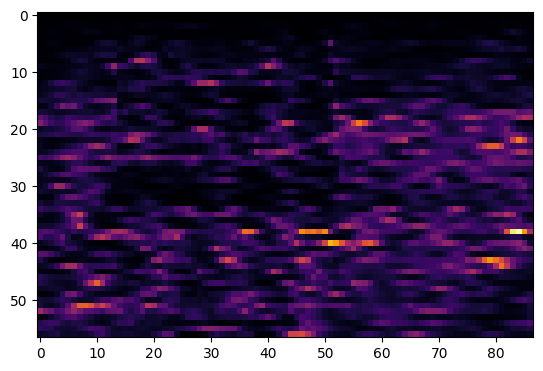

max


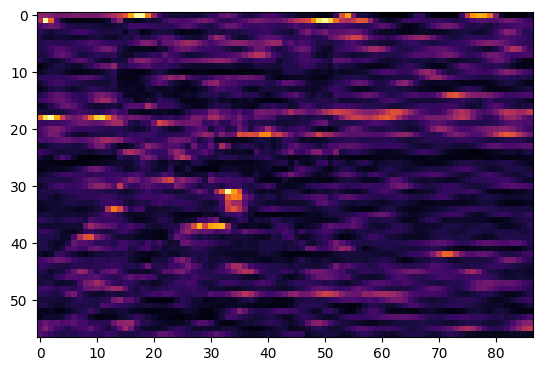

mean


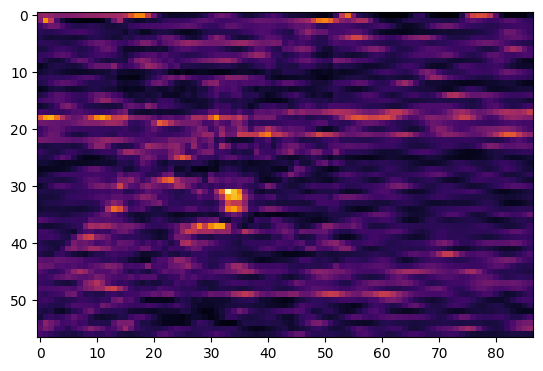

In [6]:
def interpret_attention(transformer, image):
    data = model.vit.interpret(img_tensor)

    for head_norm in data['encoders'][-1]['heads']['normalized']:
        head_norm = head_norm.detach().cpu().numpy()
        print(head_norm.shape)
        plt.imshow(head_norm, cmap='inferno')
        plt.show()
        
    for k, a in data['encoders'][-1]['aggregated'].items():
        print(k) 
        plt.imshow(a, cmap='inferno')
        plt.show()
    
    # attn_aggr = attentions_transformed.mean(axis=0)
    # plt.subplot(3, n_heads, n_heads * 2 +2)
    # plt.imshow(attn_aggr, cmap='inferno')
    # plt.title(f"Aggregated")
    # plt.show()
interpret_attention(model.vit, img_tensor)